## Introduction

Miditok is a python package used to convert MIDI music files into sequences of tokens, in order to feed sequential neural networks. It allows to encode entire datasets of symbolic music with various tokenization strategies, that all share common parameters.

# MIDI files and symbolic music

Symbolic music understanding refers to the understanding of music from the symbolic data. This means our data comes from MIDI files and not audio or sound files. Symbolic music understanding covers many music applications such as genre classification, emotion classification, and music pieces matching.

To understand what data in contained in a MIDI file, we create a short example with Musescore.

In [1]:
#Imports
import os
import sys
import librosa
import librosa.display
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib import colors
import pretty_midi
import pandas as pd
import IPython.display as ipd
import numpy as np

/home/mathieu/miniconda3/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (5.0.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


We designate our path to this .mid file :

In [1]:
os.getcwd()
MIDI_File = '/home/mathieu/Downloads/Title.mid'
#MIDI_File = '/home/mathieu/Desktop/TFE/test/TestTok.mid'
#MIDI_File = "/home/mathieu/Desktop/TFE/test/CustomCorpus/Beethoven/Beethoven, Ludwig van, 8 Variations on 'Ich hab ein kleines Hüttchen nur', Anh.10, VT2lcdx4VhE.mid"
#MIDI_File = "/home/mathieu/Desktop/TFE/test/SpatialTok.mid"

As a MIDI file is used to represent music, we can listen to the audio corresponding to that MIDI.

In [4]:
midi_data = pretty_midi.PrettyMIDI(MIDI_File) # Load MIDI file into PrettyMIDI object
Fs = 22050 # Sample frequency
audio_data = midi_data.synthesize(fs=Fs) # Synthesize the resulting MIDI data using sine waves
ipd.Audio(audio_data, rate=Fs) # Display audio

We can also extract some information from the MIDI file, such as where a note starts, where a note ends, the pitch and the velocity (loudness encoded in a discrete quantity) of a given note, and the instrument playing a note. MIDI files can also contain other musical information, such as beat or time signature indications. MIDI files often have meta-data, giving the author or the title of the piece. While MIDI encodes note timing and duration, it
does not encode qualities such as timbre. 

The information relative to our example is the following :

In [4]:
midi_list = [] # list of midi data to extract from the PrettyMIDI object

for instrument in midi_data.instruments:
    for note in instrument.notes: # the data is : note start, end, pitch, velocity and the name of the instrument.
        midi_list.append([note.start, note.end, note.pitch, note.velocity, instrument.name])

# Display pandas table
df = pd.DataFrame(midi_list, columns=['Start', 'End', 'Pitch', 'Velocity', 'Instrument'])
df.head(len(midi_list))

,Start,End,Pitch,Velocity,Instrument
0,0.00,0.473958,62,80,Piano 
1,0.50,0.973958,69,80,Piano 
2,1.75,1.986458,67,80,Piano 
3,2.00,3.898958,69,80,Piano 


A common way to visualize symbolic music is through "piano-roll" representation, that plots pitch (or note played) against time (or beat of the music). Each rectangle is a note which length corresponds to the duration of this note. It's easier to "read" the music from our example this way :

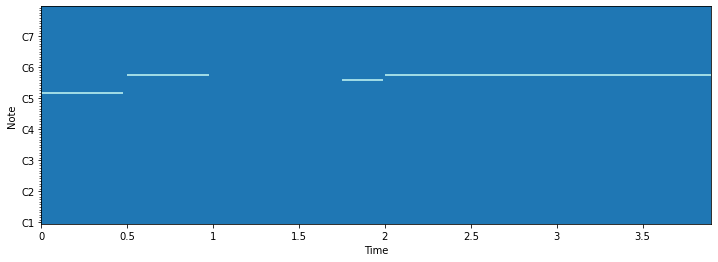

In [5]:
# Display pianoroll
midi_data = pretty_midi.PrettyMIDI(MIDI_File) 
plt.figure(figsize=(12, 4))
librosa.display.specshow(midi_data.get_piano_roll(Fs)[12:96],
                        hop_length=1, sr=Fs, x_axis='time', y_axis='cqt_note',
                        cmap=plt.cm.tab20)

# Miditok tokenization strategies

Tokenization is the process of encoding data into a sequence of *"tokens"*. This term originally designates the smallest object containing information about this data. In the case of a MIDI file which is a succession of note-related events, the translation of these events into a sequence of token is essential when anticipating to feed this data to deep learning based models. Understanding how a token-sequence is generated helps realizing the difficulty of creating *meaningfull* tokens in symbolic music encoding.

Miditok features six tokenisation methods, that can be divided into two categories:
* Single-token sequence tokenizations :

     - **Midi-Like** encodes pure MIDI messages as distinct tokens.
     - **REMI** represents time with Bar and Position tokens.
     - **Structured MIDI Encoding** that uses Duration tokens and a recurring pattern of token type successions.

* Grouped-tokens sequence tokenizations :

    - **Compound Word** reduces the length of the sequence by grouping tokens together.
    - **Octuple** groups tokens together as 8 features for each note, including the current bar, position, tempo and track information to each embedding.
    - **MuMIDI** groups tokens and focuses on multi-track information.

We start by importing Miditok and miditoolkit, that uses Mido to read and write MIDI files.

In [6]:
# Imports
import MidiTok
import miditoolkit
from miditoolkit import MidiFile

# These are the six tokenizations in miditok
from miditok import midi_like, structured, remi, cp_word, octuple_mono, mumidi, pitchmute

In MidiTok, each tokenization method contains four parameters ensuring that notes and their attributes are represented with the same precision. The following flexible parameters allow to reduce to include the specificities of each tokenization strategy.

In [7]:
# Our parameters

pitch_range = range(21,109) # Specifies the minimum and maximum pitch values. 
                            # Default pitch range from 21 to 108 covers every 
                            # recommended pitch values from the specifications.
        
beat_res = {(0, 4): 8, (4, 12): 4} # Specifies the sample rates per beat and the beat ranges to apply them.
                                    # Here, beats 1 to 4 will be quantized at 8 samples per beat, 
                                    # and beats 5 to 12 at 4 samples per beat. 
                                    # This allows the creation of accurate duration and time-shift values 
                                    # for short notes and less accurate values for longer notes. 
    
nb_velocities = 32 # The velocities of a MIDI, from 0 to 127, will be quantized into 32 values.

Similarly to the featured encoding methods, MidiTok proposes to include additional tokens within the sequences.

In [8]:
# MidiTok proposes to include additional tokens within the sequences.

additional_tokens = {'Chord': True, # Indicates that a chord is being played at the current time step. 
                     
                     'Rest': True, # Acts as a "Time-Shift" event moving the time 
                                   # from section where no note is being played. 
                     
                     'Tempo': True, # Informs of the current tempo.
                     
                     'Program': False, # For multitrack.
                     
                     #--------------------------------------------------------------------------------#
                     'rest_range': (2, 8),  # (half, 8 beats)
                     'nb_tempos': 32,  # nb of tempo bins
                     'tempo_range': (40, 250), # (min, max)
                     
                     #--------------------------------------------------------------------------------#
                     'TimeSignature': False, # Miditok's time signature addition isn't finished yet.
                     'time_signature_range': (4,1)}  # Miditok only works in 4/4 time signature yet.

## Single-token sequence tokenizations

### MIDI-Like Encoding

This method simply encodes the MIDI messages (Note On, Note Off, Velocity and Time Shift) into tokens.

We can view that Miditok encodes the example midi into a single sequence of integers, each of which are tokens representing a MIDI event.

In [9]:
# Load a MIDI file
midi = MidiFile(MIDI_File)

# Create tokenizer
tokenizer_MIDILike = midi_like.MIDILike(pitch_range, beat_res, nb_velocities, additional_tokens)

# Convert MIDI to tokens
tokens_MIDILike = tokenizer_MIDILike.midi_to_tokens(midi)
print(tokens_MIDILike)

[[311, 42, 196, 216, 130, 49, 196, 216, 137, 291, 290, 47, 196, 212, 135, 49, 196, 238, 137]]


Following, we will call **vocabulary** the list of all unique tokens found in a corpus of token-sequences. Since *vocabulary* is relative to a corpus, we can also view the vocabulary relative to each token sequence individually.

Similarly, we will call **lexicon** the register of all possible tokens that a tokenization (and its given parameters) allows, independantly from any dataset. For example in the MIDI-Like Encoding method, the size of a lexicon according 128 possible pitches, 125 values of timeshift and 32 possible velocities, is 413 tokens.

**NOTE :** These definitions will be enlarged when treating grouped-tokens sequences.

When working on datasets of MIDI files, statistics about the length of the token-sequences, tokens (or grouped-tokens) frequency, and the size of vocabulary are key elements to compare.

In [10]:
#Display token sequence length and vocabulary
vocabulary, counts = np.unique(tokens_MIDILike[0], return_counts=True)

print('Number of tokens in the sequence =', len(tokens_MIDILike[0]))
print('Vocabulary size =', len(vocabulary))
print('Vocabulary =', vocabulary)
print('Count =', counts) # Number of presencies of each token in the token sequence
                         # (given in the same order as vocabulary)

Number of tokens in the sequence = 19
Vocabulary size = 13
Vocabulary = [ 42  47  49 130 135 137 196 212 216 238 290 291 311]
Count = [1 1 2 1 1 2 4 1 2 1 1 1 1]


The MIDI-Like method gives a token sequence with a nested structure, unnecessarily complex in a non-live context and thus possibly hindering the performances of generative algorithms.
This tokenization also carry the risk of generating ill-formed sequences with notes-on event not being properly switched off.

### Structured MIDI Encoding

Similar to the previous method, Structured MIDI encoding uses Duration tokens instead Note-Off tokens. 
The main advantage of this encoding is the consistent token type transitions and the token sequence's structure it imposes, which can greatly speed up training.

This note-centered method generates strict sequences of Pitch, Velocity, Duration, and Time-Shift tokens. As a result, the size of its lexicon is often smaller than the MIDILike Encoding method's.

In [11]:
# Create tokenizer
tokenizer_Structured = structured.Structured(pitch_range, beat_res, nb_velocities, additional_tokens)

# Convert MIDI to tokens
tokens_Structured = tokenizer_Structured.midi_to_tokens(midi)
print(tokens_Structured)

[[42, 108, 128, 193, 49, 108, 128, 205, 47, 108, 124, 189, 49, 108, 150]]


In [12]:
#Display token sequence length and vocabulary
vocabulary, counts = np.unique(tokens_Structured[0], return_counts=True)

print('Number of tokens in the sequence =', len(tokens_Structured[0]))
print('Vocabulary size =', len(vocabulary))
print('Vocabulary =', vocabulary)
print('Count =', counts) # Number of presencies of each token in the token sequence
                         # (given in the same order as vocabulary)

Number of tokens in the sequence = 15
Vocabulary size = 10
Vocabulary = [ 42  47  49 108 124 128 150 189 193 205]
Count = [1 1 2 4 1 2 1 1 1 1]


In those two tokenization methods, a note is still associated with a *time* whereas humans tend to organize their music over regularly recurring patterns and accents over a metrical structure defined in terms of sub-beats, beats, and bars. Such a structure is made clear on a score sheet or a MIDI file with notation of the time signature and bar lines, but is implicit in the token sequences. A sequence model would have to recover the metrical structure on its own from the provided sequence of tokens.

### REMI 

REMI stands for revamped MIDIderived events, to encode MIDI data following a beat-based representation. Specifically, the REMI method introduces the Bar event to indicate the beginning of a bar, and the Position events to point to certain locations within a bar. The combination of Position and Bar therefore provides an explicit metrical grid. This data representation informs models of the presence of a beat-bar hierarchical structure in music and leads to better rhythmic regularity in the case of modeling music.

Miditok also includes *'Tempo'* tokens to allow less strict placements of notes. 

In [13]:
# Create tokenizer
tokenizer_REMI = remi.REMI(pitch_range, beat_res, nb_velocities, additional_tokens)

# Convert MIDI to tokens
tokens_REMI = tokenizer_REMI.midi_to_tokens(midi)
print(tokens_REMI)

[[1, 186, 256, 43, 109, 129, 194, 256, 50, 109, 129, 236, 235, 214, 256, 48, 109, 125, 1, 186, 256, 50, 109, 151]]


REMI method's lexicon size is increased by this addition of the beat-related tokens, leading to longer token sequences.

In [14]:
#Display token sequence length and vocabulary
vocabulary, counts = np.unique(tokens_REMI[0], return_counts=True)

print('Number of tokens in the sequence =', len(tokens_REMI[0]))
print('Vocabulary size =', len(vocabulary))
print('Vocabulary =', vocabulary)
print('Count =', counts) # Number of presencies of each token in the token sequence
                         # (given in the same order as vocabulary)

Number of tokens in the sequence = 24
Vocabulary size = 14
Vocabulary = [  1  43  48  50 109 125 129 151 186 194 214 235 236 256]
Count = [2 1 1 2 4 1 2 1 2 1 1 1 1 4]


All previous tokenization represent a piece of music by a sequence of tokens drawn from a finite set of pre-defined vocabulary, or a lexicon. As so, they are categorised as *single-token sequence tokenization* : while different types of token have different properties, models usually treat them equally, like words.

## Grouped-tokens sequence tokenizations

### Compound Word

Compound Word's goal is to explicitly take into account the type of token by grouping consecutive and related tokens in a token sequence. 

This method converts a piece of music into a sequence of *"compound words"* by embedding neighboring tokens : tokens that define a musical event together are placed on the same time step and in the same compound word. These musical events can be note-related, like a new musical note, or metrical-related, like the beginning of a bar. This information is given by the *'Family'* token.

The missing token types in each compound word are replaced with *ignore* tokens.

Given these new types of tokens and token sequences, some definitions need to be adjusted :

* The length of a token sequence is determined by the number of **grouped-tokens** in it.
* The vocabulary of a given dataset is the list of all unique **grouped-tokens** found in a corpus of token-sequences generated by such a tokenization.
* As the lexicon similarly designate the register of all possible **grouped-tokens** that this tokenization  allows, it becomes clear that the number of possible grouped-tokens is exponentially huge given the parameters. Thus the grouped-tokens methods lexicon's size is a criterion hardly comparable to the lexicon sizes of single-token sequence tokenizations. 


In [15]:
# Create tokenizer
tokenizer_CPWord = cp_word.CPWord(pitch_range, beat_res, nb_velocities, additional_tokens)

# Convert MIDI to tokens
tokens_CPWord = tokenizer_CPWord.midi_to_tokens(midi)
print(tokens_CPWord)

[[[3, 1, 4, 93, 126, 224, 242, 252], [3, 192, 4, 93, 126, 224, 242, 265], [2, 191, 46, 113, 134, 224, 242, 252], [3, 200, 4, 93, 126, 224, 242, 265], [2, 191, 53, 113, 134, 224, 242, 252], [3, 191, 4, 93, 126, 224, 244, 252], [3, 191, 4, 93, 126, 224, 243, 252], [3, 220, 4, 93, 126, 224, 242, 265], [2, 191, 51, 113, 130, 224, 242, 252], [3, 1, 4, 93, 126, 224, 242, 252], [3, 192, 4, 93, 126, 224, 242, 265], [2, 191, 53, 113, 156, 224, 242, 252]]]


In [16]:
#Display token sequence length and vocabulary
vocabulary, counts = np.unique(np.array(tokens_CPWord[0]), axis=0, return_counts=True)

print('Number of grouped-tokens =', len(tokens_CPWord[0]))
print('Vocabulary size =', len(vocabulary))
print('Vocabulary =', '\n', vocabulary)
print('Count =', counts) # Number of presencies of each group-token in the token sequence
                         # (given in the same order as vocabulary)

Number of grouped-tokens = 12
Vocabulary size = 10
Vocabulary = 
 [[  2 191  46 113 134 224 242 252]
 [  2 191  51 113 130 224 242 252]
 [  2 191  53 113 134 224 242 252]
 [  2 191  53 113 156 224 242 252]
 [  3   1   4  93 126 224 242 252]
 [  3 191   4  93 126 224 243 252]
 [  3 191   4  93 126 224 244 252]
 [  3 192   4  93 126 224 242 265]
 [  3 200   4  93 126 224 242 265]
 [  3 220   4  93 126 224 242 265]]
Count = [1 1 1 1 2 1 1 2 1 1]


To escape the ambiguity of calling "tokens" the grouped-tokens that constitutes our token sequence, we categorize this tokenization method (and the two following methods) as a *Grouped-tokens seauence tokenization*.

### Octuple

The goal of Octuple is to reduce the length of grouped-tokens sequences and to create a simpler and  universal symbolic music encoding method. It is a note-centered tokenization, that encodes each note into a grouped-token containing the same 8 token attributes.

In the parameters we disabled Program and TimeSignature tokens so Miditok returns sequences of grouped-tokens each containing 6 tokens.

In [17]:
# Create tokenizer
tokenizer_OctupleMono = octuple_mono.OctupleMono(pitch_range, beat_res, nb_velocities, additional_tokens)

# Convert MIDI to tokens
tokens_OctupleMono = tokenizer_OctupleMono.midi_to_tokens(midi)
print(tokens_OctupleMono)

[[[42, 108, 128, 185, 250, 229], [49, 108, 128, 193, 250, 229], [47, 108, 124, 213, 250, 229], [49, 108, 150, 185, 251, 229]]]


In [18]:
#Display token sequence length and vocabulary
vocabulary, counts = np.unique(np.array(tokens_OctupleMono[0]), axis=0, return_counts=True)

print('Number of tokens =', len(tokens_OctupleMono[0]))
print('Vocabulary size =', len(vocabulary))
print('Vocabulary =', '\n', vocabulary)
print('Count =', counts) # Number of presencies of each group-token in the token sequence
                         # (given in the same order as vocabulary)

Number of tokens = 4
Vocabulary size = 4
Vocabulary = 
 [[ 42 108 128 185 250 229]
 [ 47 108 124 213 250 229]
 [ 49 108 128 193 250 229]
 [ 49 108 150 185 251 229]]
Count = [1 1 1 1]


These short sequences and highly informative grouped-tokens, along with a token masking strategy inside each bar, allow better results on music understanding tasks like melody completion, accompaniment suggestion or classification.

### MuMIDI

Previous tokenizations where often used in tasks such as generating tracks separately, while the music notes from different tracks do not explicitly depend on each other, hurting the harmony modeling.
The MuMIDI tokenization method enables simultaneous multi-track information in a single sequence explicitly models the dependency of the notes from different tracks.

At each time step, the group-token is the sum of Bar, Position,  and Meta (such as Tempo) information, completed with the usual other tokens. The information of the track or instrument is contained in the *Program* token.

In [19]:
# Create tokenizer
tokenizer_MuMIDI = mumidi.MuMIDI(pitch_range, beat_res, nb_velocities, additional_tokens)

# Convert MIDI to tokens
tokens_MuMIDI = tokenizer_MuMIDI.midi_to_tokens(midi)
print(tokens_MuMIDI)

[[440, 246, 441, 291], [247, 247, 441, 291], [312, 247, 441, 291], [42, 169, 189, 247, 441, 291], [255, 255, 441, 291], [312, 255, 441, 291], [49, 169, 189, 255, 441, 291], [275, 275, 441, 291], [312, 275, 441, 291], [47, 169, 185, 275, 441, 291], [440, 246, 442, 291], [247, 247, 442, 291], [312, 247, 442, 291], [49, 169, 211, 247, 442, 291]]


In [20]:
#Display token sequence length and vocabulary
vocabulary, counts = np.unique(tokens_MuMIDI, return_counts=True)

print('Number of tokens =', len(tokens_MuMIDI))
print('Vocabulary size =', len(vocabulary))
print('Vocabulary =', '\n', vocabulary)
print('Count =', counts) # Number of presencies of each group-token in the token sequence
                         # (given in the same order as vocabulary)

Number of tokens = 14
Vocabulary size = 14
Vocabulary = 
 [list([42, 169, 189, 247, 441, 291]) list([47, 169, 185, 275, 441, 291])
 list([49, 169, 189, 255, 441, 291]) list([49, 169, 211, 247, 442, 291])
 list([247, 247, 441, 291]) list([247, 247, 442, 291])
 list([255, 255, 441, 291]) list([275, 275, 441, 291])
 list([312, 247, 441, 291]) list([312, 247, 442, 291])
 list([312, 255, 441, 291]) list([312, 275, 441, 291])
 list([440, 246, 441, 291]) list([440, 246, 442, 291])]
Count = [1 1 1 1 1 1 1 1 1 1 1 1 1 1]


/home/mathieu/miniconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


# Comparing Tokenization methods

We can compare some relevant data from different tokenizations of a dataset.

In [21]:
from pathlib import Path
import toolbox
from toolbox import tokenizer_method, tokenize_dataset_single, tokenize_dataset_grouped
from miditok import pitchshift

In [22]:
# Indicate the path to our dataset
dataset_path = r'/home/mathieu/Desktop/TFE/test/CustomCorpus/Beethoven'

# Choose a tokenization
  # 0 : MIDILike  # 1 : Structured MIDI   # 2 : REMI   # 3 : Compound Word   # 4 : Octuple    # 5 : MuMIDI    # 6 : Pitchshift

tokenization_method = 2  # uses defaults parameters

In the case of single-token sequence tokenization, DATA is a 5-object list containing :

- The dataset vocabulary as a dictionnary : 
```python
# { token : number of occurrencies of this token in the sequences from the dataset }
```
- The average, minimum, and maximum length of token sequences from this dataset.
- A corpus of string from the sequences of the dataset : 
```python
# ['1 23 45 205 23 ... 206', '1 23 48 245 23 ... 207', ...]
```


In [ ]:
dataset_path = r'/home/mathieu/Desktop/TFE/test/CustomCorpus/Scarlatti'
DATA = tokenize_dataset_single(dataset_path) # Method 2 is REMI

In the case of grouped-tokens sequence tokenization, DATA is a 6-object list containing :

- The dataset vocabulary as a dictionnary : 
```python
# { grouped-token : number of occurrencies of this grouped-token in the sequences from the dataset }
```
- The average, minimum, and maximum length of grouped-tokens sequences from this dataset.
- A corpus of string from the sequences of the dataset : 
```python
# ['CP1 CP23 CP45 CP205 ... CP206', 'CP1 CP23 CP48 CP245 ... CP207', ...]
```
- A lexicon related to this dataset and linking grouped-tokens and compound words in a dictionnary :
```python
# { [1, 23, 45, 206] : 'CP1', [1, 24, 45, 206] : 'CP2', ... , [1, 76, 83, 108] : 'CP8931'}
```

In [ ]:
DATA_GROUPED = tokenize_dataset_grouped(dataset_path, tokenizer_method(tokenization_method = 3)) # Method 3 is CPWord

100 files treated ...
200 files treated ...
All 274 files treated !
Average token sequence length = 3396
Minimum token sequence length = 3
Maximum token sequence length = 8193
Dataset vocabulary size = 25677
Dataset total number of tokens = 930421


These first results corrolate the prediction that grouped-token sequence tokenization generate overall shorter sequences with a much larger vocabulary.

Eventually we can try on bigger datasets (10.000 files) and condense our results into a table. The two datasets used in this example are :

* GiantMIDI : 10,855 western classical piano solo compositions from 2,786 composers. 
* ADL Piano MIDI : 11,086 piano pieces from different genres. This dataset is based on the Lakh MIDI dataset.

<img src="MethodsComparison.png" />

Finally we can gather more data about our dataset.

In [24]:
import mido as mido
from mido import MidiFile, tick2second, second2tick, bpm2tempo
import miditoolkit
import random

from toolbox import extract_from_midi, closest_beat_from_tick, get_tempo, create_midi_paths

In [ ]:
from toolbox import duration_and_notes, corpus_duration_and_notes

corpus_path = r'/home/mathieu/Desktop/TFE/test/CustomCorpus/Mozart'
[total_duration, nb_midi_paths, total_nb_of_notes] = corpus_duration_and_notes(corpus_path)

Cumulated duration of files in the dataset : 40305.65494791668 seconds.
Average duration of files in the dataset : 474 seconds.
Number of notes in the dataset : 697854 notes.


# Creating Uniform Datasets of token sequences for NLP classification

*Custom Corpus* is based on GiantMIDI Piano and only contains the midis from the seven most prolific authors.

<img src="CustomCorpus.png" />

In [ ]:
# Creates a dataset of (number_of_authors * number_of_files_per_author) tokenized midi files given :
#       - the path to the dataset containing the authors' midi files
#       - the list of authors we want in the dataset
#       - the duration of the midis extracted from those authors' midis files
#       - the quantity of midis extracted for each author
#       - the tokenization method

import pickle
from toolbox import tokens_to_CP
from miditok import pitchshift, pitchmute
from toolbox import create_sampled_dataset_single, create_sampled_dataset_grouped
from toolbox import create_y_from_dataset, create_y_binary
from toolbox import create_sampled_dataset #, create_sampled_dataset_fast


# Small test
dataset_path = r'/home/mathieu/Desktop/TFE/test/CustomCorpus'
authors_list = ['Bach', 'Liszt']
duration_midis = 60 # Duration (in seconds) of the samples we extract from midis
quantity_midis = 10 # Number of samples we want per author
test_size = 0.20
tokenizations = ['REMI', 'CPWord', 'PitchShift', 'PitchMute', 'SpatialPS']
random_state = 0

corpuses, data_shuffle, vocabularies = create_sampled_dataset(dataset_path, authors_list, duration_midis, quantity_midis, test_size, random_state, tokenizations)

In [ ]:
# Corpus of token sequence created for three pairs of authors

dataset_path = r'/home/mathieu/Desktop/TFE/test/CustomCorpus'
duration_midis = 60 # Duration (in seconds) of the samples we extract from midis
quantity_midis = 2000 # Number of samples we want per author
test_size = 0.20
tokenizations = ['REMI', 'CPWord', 'PitchShift', 'PitchMute', 'SpatialPS']
random_state = 100


authors_list = ['Bach', 'Liszt']

corpuses, data_shuffle, vocabularies = create_sampled_dataset(dataset_path, authors_list, duration_midis, quantity_midis, test_size, random_state, tokenizations)

file_name = "Bach_Liszt"

pickle.dump(corpuses, open(file_name + "_corpuses_" + str(random_state) + ".p", 'wb'))
pickle.dump(data_shuffle, open(file_name + "_data_shuffle_" + str(random_state) + ".p", 'wb'))
pickle.dump(vocabularies, open(file_name + "_vocabularies_" + str(random_state) + ".p", 'wb'))



authors_list = ['Mozart', 'Beethoven']

corpuses, data_shuffle, vocabularies = create_sampled_dataset(dataset_path, authors_list, duration_midis, quantity_midis, test_size, random_state, tokenizations)

file_name = "Mozart_Beethoven"

pickle.dump(corpuses, open(file_name + "_corpuses_" + str(random_state) + ".p", 'wb'))
pickle.dump(data_shuffle, open(file_name + "_data_shuffle_" + str(random_state) + ".p", 'wb'))
pickle.dump(vocabularies, open(file_name + "_vocabularies_" + str(random_state) + ".p", 'wb'))



authors_list = ['Chopin', 'Schubert']

corpuses, data_shuffle, vocabularies = create_sampled_dataset(dataset_path, authors_list, duration_midis, quantity_midis, test_size, random_state, tokenizations)

file_name = "Chopin_Schubert"

pickle.dump(corpuses, open(file_name + "_corpuses_" + str(random_state) + ".p", 'wb'))
pickle.dump(data_shuffle, open(file_name + "_data_shuffle_" + str(random_state) + ".p", 'wb'))
pickle.dump(vocabularies, open(file_name + "_vocabularies_" + str(random_state) + ".p", 'wb'))

In [ ]:
### 10 DATASETS for accuracy statistic

ACCURACY_REMI = []
ACCURACY_CP = []
ACCURACY_PS = []
ACCURACY_PM = []

dataset_path = r'/home/mathieu/Desktop/TFE/test/CustomCorpus'
duration_midis = 30 # Duration (in seconds) of the samples we extract from midis
quantity_midis = 1000 # Number of samples we want per author
test_size = 0.20


for i in range(10):
    ## Bach & Listz
    authors_list = ['Bach', 'Liszt']

    accuracy_scores = create_sampled_dataset_fast(dataset_path, authors_list, duration_midis, quantity_midis, test_size)
    ACCURACY_REMI.append(accuracy_scores[0])
    ACCURACY_CP.append(accuracy_scores[1])
    ACCURACY_PS.append(accuracy_scores[2])
    ACCURACY_PM.append(accuracy_scores[3])

    
    ## Mozart & Beethoven
    authors_list = ['Mozart', 'Beethoven']

    accuracy_scores = create_sampled_dataset_fast(dataset_path, authors_list, duration_midis, quantity_midis, test_size)
    ACCURACY_REMI.append(accuracy_scores[0])
    ACCURACY_CP.append(accuracy_scores[1])
    ACCURACY_PS.append(accuracy_scores[2])
    ACCURACY_PM.append(accuracy_scores[3])



    ## Chopin & Schubert
    authors_list = ['Chopin', 'Schubert']

    accuracy_scores = create_sampled_dataset_fast(dataset_path, authors_list, duration_midis, quantity_midis, test_size)
    ACCURACY_REMI.append(accuracy_scores[0])
    ACCURACY_CP.append(accuracy_scores[1])
    ACCURACY_PS.append(accuracy_scores[2])
    ACCURACY_PM.append(accuracy_scores[3])

    print("============ i : " + str(i) + " ============")
    print(ACCURACY_REMI, ACCURACY_CP, ACCURACY_PS, ACCURACY_PM)


# Exploration on token weights

Some of the data sampled from the previous dataset tokenizations can be used in NLP considering tokens as words.

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.dummy import DummyClassifier

import pickle
import seaborn
from miditok import midi_tokenizer_base
from seaborn import histplot, barplot
from toolbox import get_key

In [ ]:
target_names = ['Bach', 'Liszt']

corpuses = pickle.load(open( "Bach_Liszt_corpuses_100.p", "rb" ))
data_shuffle = pickle.load(open( "Bach_Liszt_data_shuffle_100.p", "rb" ))
vocabularies = pickle.load(open( "Bach_Liszt_vocabularies_100.p", "rb" ))

Vocabulary size =  276
Accuracy score =  0.8909774436090225


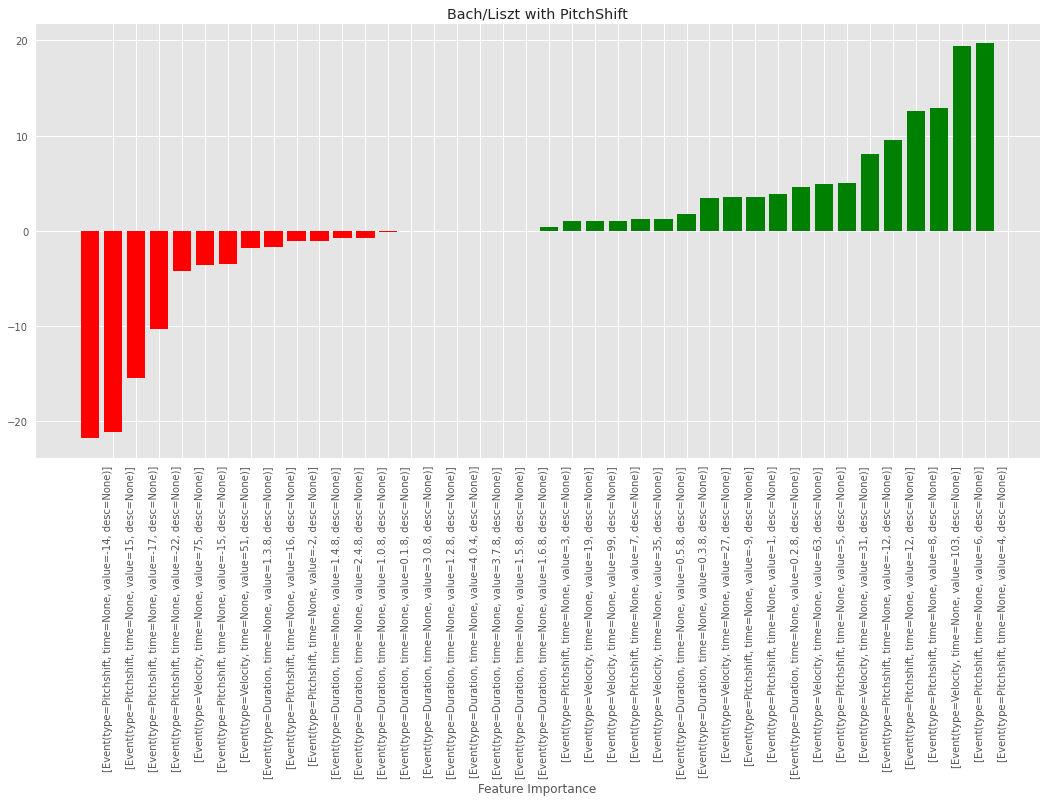

In [ ]:
authors_list = ['Bach', 'Liszt']
method = 'PitchShift' # 'CPWord', 'PitchShift', 'PitchMute'
target_names = authors_list
CORPUS = corpuses[2] #CORPUS_CP = corpuses[1], CORPUS_PS = corpuses[2], CORPUS_PM = corpuses[3]
VOCAB = vocabularies[2] #VOCAB_CP = vocabularies[1][0], vocabularies[2], vocabularies[3]
#lexique_cp = vocabularies[1][1]


# Binary author classification
X_train_processed, X_test_processed, y_train, y_test, y_pred, coef, labels, acc_score = binary_classification(CORPUS, VOCAB, method, target_names)

#X_train_processed, X_test_processed, y_train, y_test, y_pred, coef, labels, acc_score = binary_classification_cp(CORPUS, VOCAB, lexique_cp, method, target_names)

In [28]:
import seaborn as sns

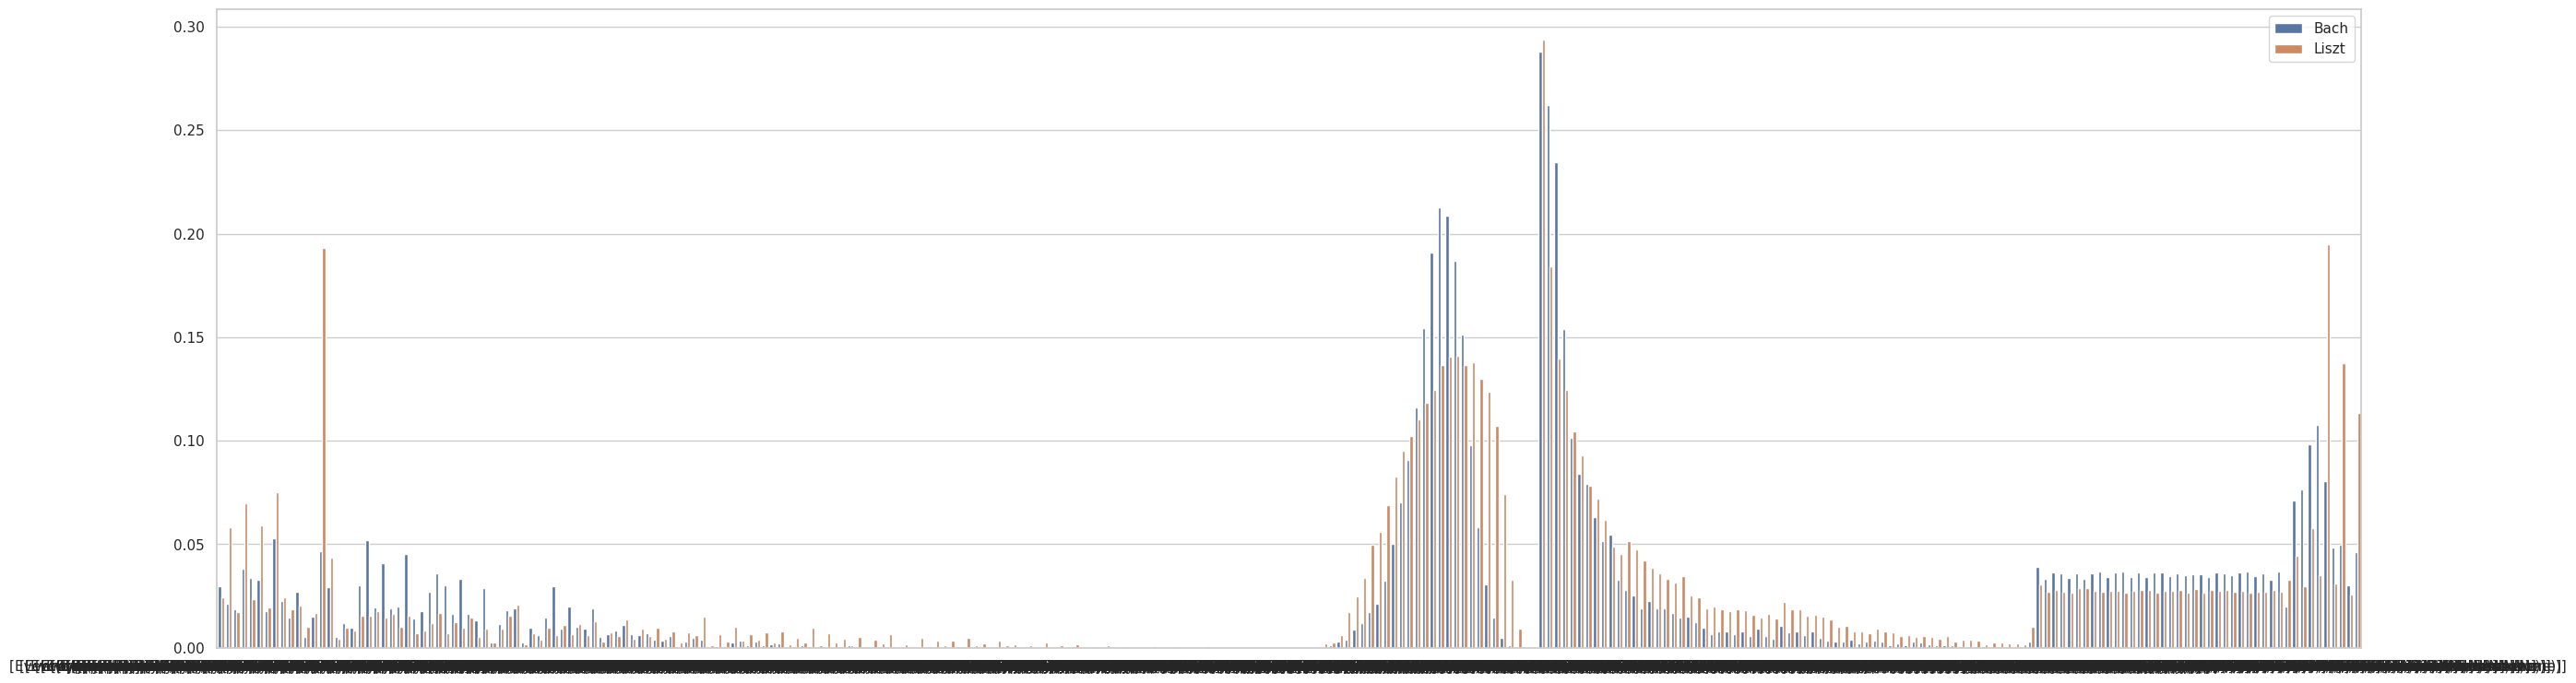

In [ ]:
# Gather test tokens coeffs into panda dataframe
X_test_processed_coef = X_test_processed.toarray()
pd_X_test_processed_coef = pd.DataFrame(X_test_processed_coef, columns=labels)

data = {'Token_name': [], 'Token_weight': [], 'Author': []}

# Look out for token statistics
for str_token in labels:
    token_weight_auth1, token_weight_auth2 = token_stat(str_token, pd_X_test_processed_coef, y_test)
    data['Token_name'].append(str_token)
    data['Token_name'].append(str_token)
    data['Token_weight'].append(token_weight_auth1)
    data['Token_weight'].append(token_weight_auth2)
    data['Author'].append(y_test[0][0])
    data['Author'].append(y_test[-1][0])

#str_token = '[Event(type=Pitch, time=None, value=86, desc=None)]'
#token_weight(str_token, coef, labels)

# Plot test tokens average weights
#plt.figure(figsize=(20, 50))
#barplot(data = pd_X_test_processed_coef, orient = "h", ci = None, color="salmon", saturation=.5)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(30, 9))
ax = sns.barplot(x="Token_name", y="Token_weight", hue="Author", data=data, orient = "v")

In [ ]:
for str_token in labels:
    token_weight_auth1, token_weight_auth2 = token_stat(str_token, pd_X_test_processed_coef, y_test)
    print(token_weight_auth2)

In [ ]:
token_weight(labels[-5], coef, labels)
token_stat(labels[-5], pd_X_test_processed_coef, y_test)

[Event(type=Pitchshift, time=None, value=3, desc=None)] coef = 0.3929462468578975


(0.08027645339794826, 0.1950926548883051)

In [ ]:
token_weight(labels[13], coef, labels)
token_stat(labels[13], pd_X_test_processed_coef, y_test)

[Event(type=Pitchshift, time=None, value=12, desc=None)] coef = 9.516892514871719


(0.04683721880069579, 0.1928947671664878)

In [ ]:
str_token = '[Event(type=Pitch, time=None, value=86, desc=None)]'
token_weight(str_token, coef, labels)
token_stat(str_token, pd_X_test_processed_coef, y_test)

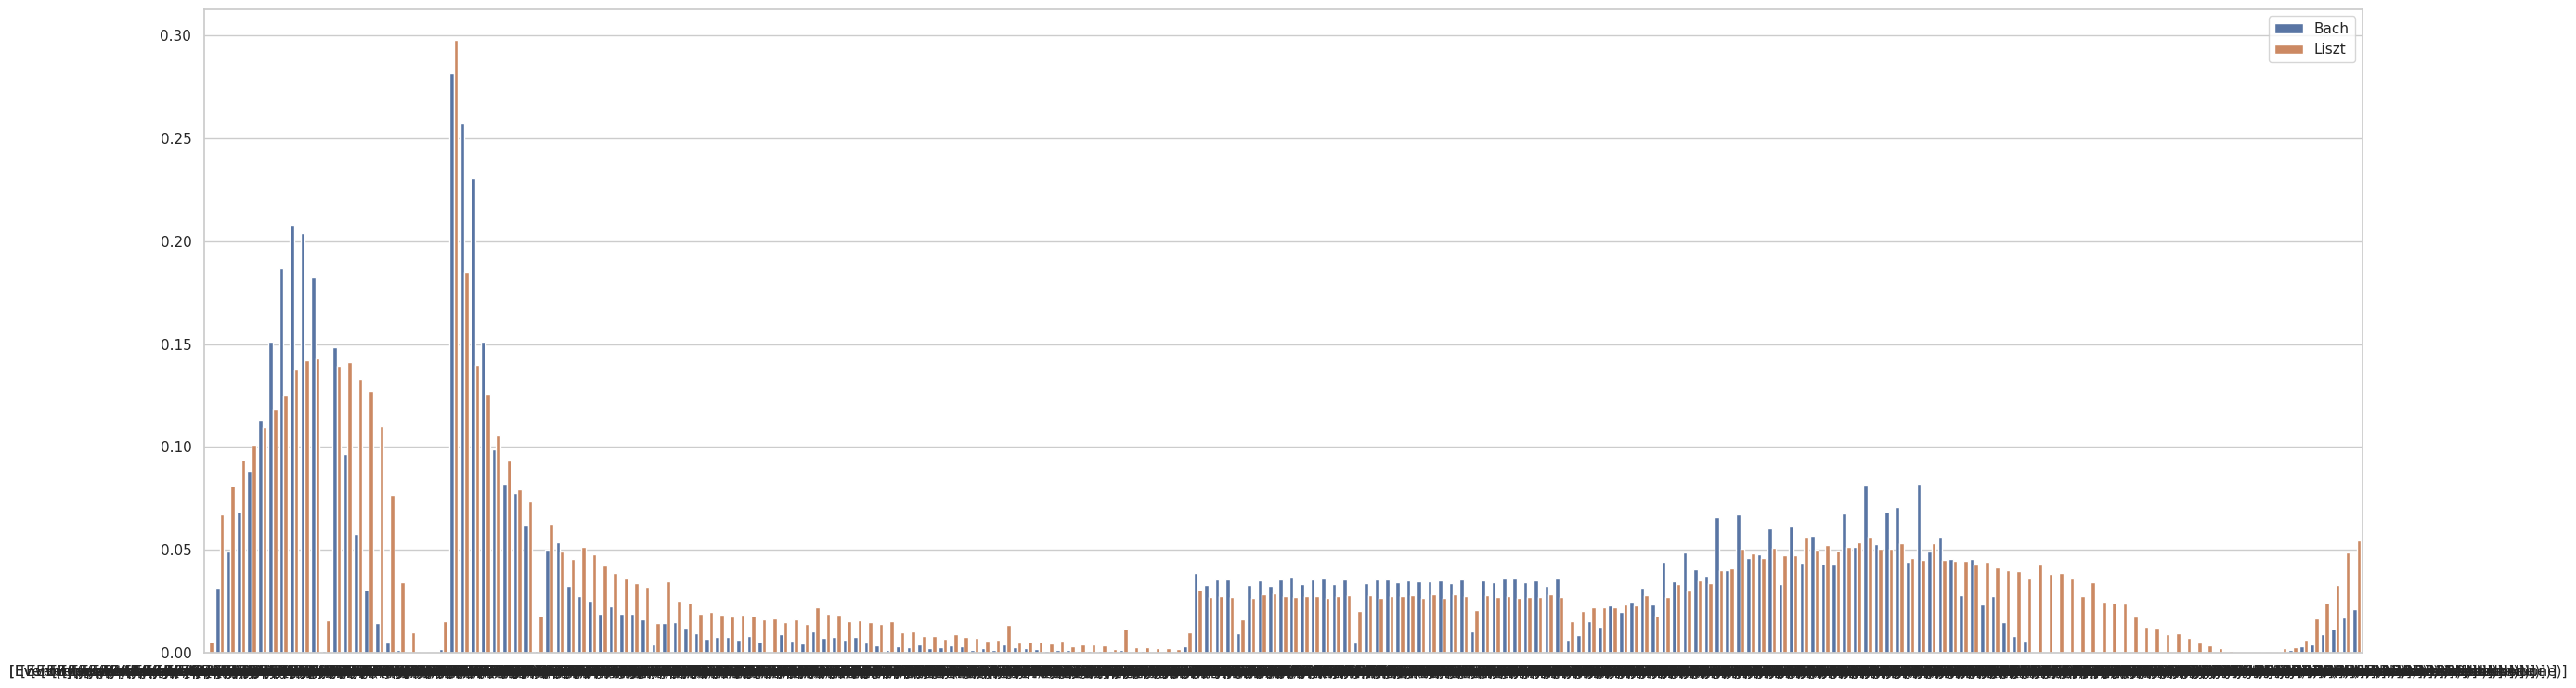

In [ ]:
# Gather test tokens coeffs into panda dataframe
X_test_processed_coef = X_test_processed.toarray()
pd_X_test_processed_coef = pd.DataFrame(X_test_processed_coef, columns=labels)

data = {'Token_name': [], 'Token_weight': [], 'Author': []}

# Look out for token statistics
for str_token in labels:
    token_weight_auth1, token_weight_auth2 = token_stat(str_token, pd_X_test_processed_coef, y_test)
    data['Token_name'].append(str_token)
    data['Token_name'].append(str_token)
    data['Token_weight'].append(token_weight_auth1)
    data['Token_weight'].append(token_weight_auth2)
    data['Author'].append(y_test[0][0])
    data['Author'].append(y_test[-1][0])

#str_token = '[Event(type=Pitch, time=None, value=86, desc=None)]'
#token_weight(str_token, coef, labels)

# Plot test tokens average weights
#plt.figure(figsize=(20, 50))
#barplot(data = pd_X_test_processed_coef, orient = "h", ci = None, color="salmon", saturation=.5)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(30, 9))
ax = sns.barplot(x="Token_name", y="Token_weight", hue="Author", data=data, orient = "v")

In [ ]:
def token_stat(token_str, pd_X_test_processed_coef, y_test):
    pd_X_test_processed_coef['y'] = [str(author_in_list[0]) for author_in_list in y_test]

    # Lisibility
    M = pd_X_test_processed_coef
    author1 = y_test[0][0]
    author2 = y_test[-1][0]

    token_weight_auth1 = M[M['y'] == author1][token_str].mean()
    token_weight_auth2 = M[M['y'] == author2][token_str].mean()

    # Results
    #print('Average token weight for both authors = ' + str(M[token_str].mean()))
    #print('Average token weight for ' + author1 + ' = ' + str(token_weight_auth1))
    #print('Average token weight for ' + author2 + ' = ' + str(token_weight_auth2))

    return token_weight_auth1, token_weight_auth2


def token_weight(token_str, coef, labels):
    print(token_str + " coef = " + str(coef[labels.index(token_str)]))
    return

In [ ]:
def binary_classification(CORPUS, VOCAB, method, target_names):
    # Gather our data
    X_train, X_test, y_train, y_test = CORPUS[0], CORPUS[1], CORPUS[2], CORPUS[3]
    y_true = y_test # Useless but still

    # Initiate regressor and vectorizer
    regressor = LogisticRegression(penalty = 'l1', solver = 'saga', max_iter=10000) # max_iter
    vectorizer = TfidfVectorizer()

    # Process data
    X_train_processed = vectorizer.fit_transform(X_train)
    X_test_processed = vectorizer.transform(X_test)
    regressor = regressor.fit(X_train_processed, y_train)
    y_pred = regressor.predict(X_test_processed)

    # Print first results
    print('Vocabulary size = ', len(regressor.coef_[0]))
    print('Accuracy score = ', accuracy_score(y_true, y_pred))

    # Gather weights and token names
    coef = regressor.coef_.ravel()
    feature_names = np.array(vectorizer.get_feature_names_out())

    # Get the real significance of the tokens from the vocabulary
    labels = []
    for token in feature_names.tolist():
        labels.append(VOCAB[token])

    # Plot interesting features
    positive_coeffs = np.argsort(coef)[-20:]
    negative_coeffs = np.argsort(coef)[:20]
    interesting_coeffs = np.hstack([negative_coeffs, positive_coeffs])
    with plt.style.context(('seaborn', 'ggplot')):
        plt.figure(figsize=(18, 8))
        colors = ["red" if c < 0 else "green" for c in coef[interesting_coeffs]]
        plt.bar(np.arange(2 * 20), coef[interesting_coeffs], color=colors)
        feature_names = np.array(vectorizer.get_feature_names_out())
        labels_interesting = []
        for token in feature_names[interesting_coeffs]:
            labels_interesting.append(VOCAB[str(token)])
        plt.xticks(np.arange(1, 2 * 20 + 1), labels_interesting, rotation=90, ha="right")
        plt.xlabel('Feature Importance')
        plt.title(target_names[0] + '/' + target_names[1] + ' with ' + method)

    return X_train_processed, X_test_processed, y_train, y_test, y_pred, coef, labels, accuracy_score(y_true, y_pred)

In [ ]:
def binary_classification_cp(CORPUS, VOCAB, lexique, method, target_names):
    # Gather our data
    X_train, X_test, y_train, y_test = CORPUS[0], CORPUS[1], CORPUS[2], CORPUS[3]
    y_true = y_test # Useless but still

    # Initiate regressor and vectorizer
    regressor = LogisticRegression(penalty = 'l1', solver = 'saga', max_iter=10000) # max_iter
    vectorizer = TfidfVectorizer()

    # Process data
    X_train_processed = vectorizer.fit_transform(X_train)
    X_test_processed = vectorizer.transform(X_test)
    regressor = regressor.fit(X_train_processed, y_train)
    y_pred = regressor.predict(X_test_processed)

    # Print first results
    print('Vocabulary size = ', len(regressor.coef_[0]))
    print('Accuracy score = ', accuracy_score(y_true, y_pred))

    # Gather weights and token names
    coef = regressor.coef_.ravel()
    feature_names = np.array(vectorizer.get_feature_names_out())

    # Get the real significance of the tokens from the vocabulary
    labels = []
    for token in feature_names.tolist():
        labels.append(VOCAB[get_key(lexique, token.upper())])

    # Plot interesting features
    positive_coeffs = np.argsort(coef)[-20:]
    negative_coeffs = np.argsort(coef)[:20]
    interesting_coeffs = np.hstack([negative_coeffs, positive_coeffs])
    with plt.style.context(('seaborn', 'ggplot')):
        plt.figure(figsize=(18, 8))
        colors = ["red" if c < 0 else "green" for c in coef[interesting_coeffs]]
        plt.bar(np.arange(2 * 20), coef[interesting_coeffs], color=colors)
        feature_names = np.array(vectorizer.get_feature_names_out())

        labels_interesting = []
        for token in feature_names[interesting_coeffs]:
            labels_interesting.append(VOCAB[get_key(lexique, token.upper())])

        plt.xticks(np.arange(1, 2 * 20 + 1), labels_interesting, rotation=90, ha="right")
        plt.xlabel('Feature Importance')
        plt.title(target_names[0] + '/' + target_names[1] + ' with ' + method)

    return X_train_processed, X_test_processed, y_train, y_test, y_pred, coef, labels, accuracy_score(y_true, y_pred)

In [ ]:
def show_moustache(csv_path):
    df = pd.read_csv(csv_path, sep=' ', header=None, index_col=False)
    data = []
    for acc_list in df.values:
        data.append(acc_list)
    df2 = pd.DataFrame(np.transpose(data), columns = ['REMI (DA)', 'REMI','CPWord (DA)', 'CPWord', 'PitchShift', 'SpatialPS', 'PitchMute'])
    with plt.style.context(('seaborn', 'ggplot')):
        plt.figure(figsize=(10, 15))
        plt.xlabel('Accuracy')
        plt.ylabel('Tokenization')
        plt.ylim([0.5, 1])
        plt.title(csv_path)
        sns.boxplot(data = df2, orient="v")


# End-of-phrase detection in TAVERN corpus


In [8]:
from music21 import *

#file_name = "/home/mathieu/Desktop/TFE/test/TAVERN-master/Mozart/K025/Joined/M025_00_01a_b.krn"

s = converter.parse(file_name)

midi_data = pretty_midi.PrettyMIDI("/home/mathieu/Desktop/TFE/test/score.mid") # Load MIDI file into PrettyMIDI object
Fs = 44100 # Sample frequency
audio_data = midi_data.synthesize(fs=Fs) # Synthesize the resulting MIDI data using sine waves
ipd.Audio(audio_data, rate=Fs) # Display audio




[<music21.stream.Part 0x7ff988a60880>, <music21.stream.Measure 1 offset=0.0>, <music21.instrument.Piano 'Piano: Piano'>, <music21.clef.TrebleClef>, <music21.tempo.MetronomeMark animato Quarter=120.0>, <music21.key.Key of C major>, <music21.meter.TimeSignature 4/4>, <music21.note.Note C>, <music21.note.Note G>, <music21.note.Note C>, <music21.bar.Barline type=final>]


In [30]:
os.remove('score.mid')

In [33]:
from os import walk, path
from toolbox import tokens_to_CP, transpose_midi
from miditok import pitchshift, pitchmute, spatialpitchshift
from music21 import *

dataset_path = "/home/mathieu/Desktop/TFE/test/TavernCorpus"
authors = ["Mozart", "Beethoven"]
tokenizations = ['REMI', 'CPWord', 'PitchShift', 'PitchMute', 'SpatialPS']
data_augmented = False

TOKENIZED_PIECES = {
    'Mozart': {
        'REMI': [],
        'CPWord': [],
        'PitchShift': [],
        'PitchMute': [],
        'SpatialPS': [],
        'REMI_DA': [],
        'CPWord_DA': []
    },
    'Beethoven': {
        'REMI': [],
        'CPWord': [],
        'PitchShift': [],
        'PitchMute': [],
        'SpatialPS': [],
        'REMI_DA': [],
        'CPWord_DA': []
    }
}

lexique = {}

TOKENIZER_DIC = {
        'REMI': remi.REMI(),
        'CPWord': cp_word.CPWord(),
        'PitchShift': pitchshift.PITCHSHIFT(),
        'PitchMute': pitchmute.PITCHMUTE(),
        'SpatialPS': spatialpitchshift.SPATIALPITCHSHIFT()
    }
    
for author in authors:
    init = -1
    for root, dirs, files in walk(path.normpath(dataset_path + "/" + author)):
        for file in sorted(files):
            if file.endswith(".krn"):
                if init == -1:

                    current_variation = file.split('_')[0]
                    print('Appending ' + current_variation + ' ...')

                    variation_sequence = {'REMI': [], 'CPWord': [], 'PitchShift': [], 'PitchMute': [], 'SpatialPS': []}
                    init = 0

                    s = converter.parse(dataset_path + "/" + author + "/" + current_variation + "/" + file)
                    s.write('midi', 'score.mid')
                    midi = miditoolkit.MidiFile("/home/mathieu/Desktop/TFE/test/score.mid")

                    for tokenization in tokenizations: # ['REMI', 'CPWord', 'PitchShift', 'PitchMute']
                        tokenizer = TOKENIZER_DIC[tokenization]
                        token_sequence = tokenizer.midi_to_tokens(midi)
                        if token_sequence != []:
                            if tokenization == 'CPWord':
                                CP_sequence, lexique = tokens_to_CP(token_sequence[0], lexique)
                                corpus_sequence = CP_sequence.split()
                                corpus_sequence.append('END')
                                variation_sequence[tokenization].extend(corpus_sequence)
                            else:
                                corpus_sequence = [str(nb) for nb in token_sequence[0]]
                                corpus_sequence.append('END')
                                variation_sequence[tokenization].extend(corpus_sequence)
                    
                    if data_augmented:
                         variation_sequence['REMI_DA'] = {'1': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': [], '8': [], '9': [], '10': [], '11': []}
                        variation_sequence['CPWord_DA'] = {'1': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': [], '8': [], '9': [], '10': [], '11': []}
                        transpose_midi('score.mid')
                        for i in range(1, 12):
                            midi = miditoolkit.MidiFile('score_+' + str(i) + '.mid')
                            for tokenization in tokenizations:
                                tokenizer = TOKENIZER_DIC[tokenization]
                                token_sequence = tokenizer.midi_to_tokens(midi)
                                if token_sequence != []:
                                    if tokenization == 'REMI':
                                        corpus_sequence = [str(nb) for nb in token_sequence[0]]
                                        corpus_sequence.append('END')
                                        variation_sequence['REMI_DA'][str(i)].extend(corpus_sequence)
                                    if tokenization == 'CPWord':
                                        CP_sequence, lexique = tokens_to_CP(token_sequence[0], lexique)
                                        corpus_sequence = CP_sequence.split()
                                        corpus_sequence.append('END')
                                        variation_sequence['CPWord_DA'][str(i)].extend(corpus_sequence)
                            os.remove('score_+' + str(i) + '.mid')

                    os.remove('score.mid')



                else:

                    if file.split('_')[0] == current_variation:
                        
                        s = converter.parse(dataset_path + "/" + author + "/" + current_variation + "/" + file)
                        s.write('midi', 'score.mid')
                        midi = miditoolkit.MidiFile("/home/mathieu/Desktop/TFE/test/score.mid")

                        for tokenization in tokenizations: # ['REMI', 'CPWord', 'PitchShift', 'PitchMute']
                            tokenizer = TOKENIZER_DIC[tokenization]
                            token_sequence = tokenizer.midi_to_tokens(midi)
                            if token_sequence != []:
                                if tokenization == 'CPWord':
                                    CP_sequence, lexique = tokens_to_CP(token_sequence[0], lexique)
                                    corpus_sequence = CP_sequence.split()
                                    corpus_sequence.append('END')
                                    variation_sequence[tokenization].extend(corpus_sequence)
                                else:
                                    corpus_sequence = [str(nb) for nb in token_sequence[0]]
                                    corpus_sequence.append('END')
                                    variation_sequence[tokenization].extend(corpus_sequence)
                        
                        if data_augmented:
                            transpose_midi('score.mid')
                            for i in range(1, 12):
                                midi = miditoolkit.MidiFile('score_+' + str(i) + '.mid')
                                for tokenization in tokenizations:
                                    tokenizer = TOKENIZER_DIC[tokenization]
                                    token_sequence = tokenizer.midi_to_tokens(midi)
                                    if token_sequence != []:
                                        if tokenization == 'REMI':
                                            corpus_sequence = [str(nb) for nb in token_sequence[0]]
                                            corpus_sequence.append('END')
                                            variation_sequence['REMI_DA'][str(i)].extend(corpus_sequence)
                                        if tokenization == 'CPWord':
                                            CP_sequence, lexique = tokens_to_CP(token_sequence[0], lexique)
                                            corpus_sequence = CP_sequence.split()
                                            corpus_sequence.append('END')
                                            variation_sequence['CPWord_DA'][str(i)].extend(corpus_sequence)
                                os.remove('score_+' + str(i) + '.mid')

                        os.remove('score.mid')

                    else:

                        for tokenization in tokenizations:
                            TOKENIZED_PIECES[author][tokenization].append(variation_sequence[tokenization])
                        
                        if data_augmented:
                            for i in range(1, 12):
                                TOKENIZED_PIECES[author]['REMI'].append(variation_sequence['REMI_DA'][str(i)])
                                TOKENIZED_PIECES[author]['CPWord'].append(variation_sequence['CPWord_DA'][str(i)])
                            
                        print(current_variation + ' appended !')
                        
                        current_variation = file.split('_')[0]
                        print('Appending ' + current_variation + ' ...')

                        variation_sequence = {'REMI': [], 'CPWord': [], 'PitchShift': [], 'PitchMute': [], 'SpatialPS': []}

                        s = converter.parse(dataset_path + "/" + author + "/" + current_variation + "/" + file)
                        s.write('midi', 'score.mid')
                        midi = miditoolkit.MidiFile("/home/mathieu/Desktop/TFE/test/score.mid")

                        for tokenization in tokenizations: # ['REMI', 'CPWord', 'PitchShift', 'PitchMute']
                            tokenizer = TOKENIZER_DIC[tokenization]
                            token_sequence = tokenizer.midi_to_tokens(midi)
                            if token_sequence != []:
                                if tokenization == 'CPWord':
                                    CP_sequence, lexique = tokens_to_CP(token_sequence[0], lexique)
                                    corpus_sequence = CP_sequence.split()
                                    corpus_sequence.append('END')
                                    variation_sequence[tokenization].extend(corpus_sequence)
                                else:
                                    corpus_sequence = [str(nb) for nb in token_sequence[0]]
                                    corpus_sequence.append('END')
                                    variation_sequence[tokenization].extend(corpus_sequence)

                        if data_augmented:
                            variation_sequence['REMI_DA'] = {'1': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': [], '8': [], '9': [], '10': [], '11': []}
                            variation_sequence['CPWord_DA'] = {'1': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': [], '8': [], '9': [], '10': [], '11': []}
                            transpose_midi('score.mid')
                            for i in range(1, 12):
                                midi = miditoolkit.MidiFile('score_+' + str(i) + '.mid')
                                for tokenization in tokenizations:
                                    tokenizer = TOKENIZER_DIC[tokenization]
                                    token_sequence = tokenizer.midi_to_tokens(midi)
                                    if token_sequence != []:
                                        if tokenization == 'REMI':
                                            corpus_sequence = [str(nb) for nb in token_sequence[0]]
                                            corpus_sequence.append('END')
                                            variation_sequence['REMI_DA'][str(i)].extend(corpus_sequence)
                                        if tokenization == 'CPWord':
                                            CP_sequence, lexique = tokens_to_CP(token_sequence[0], lexique)
                                            corpus_sequence = CP_sequence.split()
                                            corpus_sequence.append('END')
                                            variation_sequence['CPWord_DA'][str(i)].extend(corpus_sequence)
                                os.remove('score_+' + str(i) + '.mid')

                        os.remove('score.mid')
    
    print(author + "'s files have been tokenized !")

for tokenization in tokenizations:
    TOKENIZED_PIECES[authors[1]][tokenization].append(variation_sequence[tokenization])
if data_augmented:
    for i in range(1, 12):
        TOKENIZED_PIECES[authors[1]]['REMI'].append(variation_sequence['REMI_DA'][str(i)])
        TOKENIZED_PIECES[authors[1]]['CPWord'].append(variation_sequence['CPWord_DA'][str(i)])


pickle.dump(TOKENIZED_PIECES, open("TavernCorpus_TOKENIZED_PIECES_DA.p", 'wb'))

Appending M573 ...
M573 appended !
Appending M179 ...
M179 appended !
Appending M354 ...
M354 appended !
Appending M353 ...


humdrum.spineParser: WARNING: Error in parsing event ('8r 8r') at position 51 for spine None: 'Rest' object has no attribute 'beams'
humdrum.spineParser: WARNING: Error in parsing event ('8r 8r') at position 53 for spine None: 'Rest' object has no attribute 'beams'
humdrum.spineParser: WARNING: Error in parsing event ('*clefG2a') at position 22 for spine None: Unknown clef type *clefG2a found


M353 appended !
Appending M025 ...
M025 appended !
Appending M613 ...


humdrum.spineParser: WARNING: Error in parsing event ('*clefF7d') at position 4 for spine None: Unknown clef type *clefF7d found


M613 appended !
Appending M398 ...
M398 appended !
Appending M501 ...
M501 appended !
Appending M455 ...
M455 appended !
Appending M265 ...


humdrum.spineParser: WARNING: Error in parsing event ('16)') at position 122 for spine None: Could not parse 16) for note information
humdrum.spineParser: WARNING: Error in parsing event ('16)') at position 130 for spine None: Could not parse 16) for note information


Mozart's files have been tokenized !
Appending B072 ...


humdrum.spineParser: WARNING: Error in parsing event ('4r 4G') at position 62 for spine None: Could not process input argument <music21.note.Rest quarter>
humdrum.spineParser: WARNING: Error in parsing event ('4r 4r') at position 63 for spine None: 'Rest' object has no attribute 'beams'
humdrum.spineParser: WARNING: Error in parsing event ('4r 4r') at position 65 for spine None: 'Rest' object has no attribute 'beams'


B072 appended !
Appending B068 ...
B068 appended !
Appending B073 ...
B073 appended !
Appending B076 ...
B076 appended !
Appending B066 ...
B066 appended !
Appending BO76 ...
BO76 appended !
Appending B077 ...
B077 appended !
Appending B075 ...
B075 appended !
Appending B080 ...
B080 appended !
Appending B069 ...
B069 appended !
Appending B070 ...
B070 appended !
Appending B071 ...
B071 appended !
Appending B078 ...
B078 appended !
Appending B065 ...
B065 appended !
Appending B064 ...
B064 appended !
Appending BO34 ...
BO34 appended !
Appending B063 ...
Beethoven's files have been tokenized !


In [4]:
from sklearn.model_selection import ShuffleSplit
import random
import pickle


TOKENIZED_PIECES = pickle.load(open("TavernCorpus_TOKENIZED_PIECES.p", "rb" ))
authors = ["Mozart", "Beethoven"]
tokenizations = ['REMI', 'CPWord', 'PitchShift', 'PitchMute', 'SpatialPS']

train_size = 0.6
test_size = 1 - train_size
random_state = 0

rs = ShuffleSplit(n_splits=1, train_size=train_size, test_size=test_size, random_state=random_state)


In [7]:
CORPUS_DIC = {
        'REMI': [[], [], [], []], # X_train, X_test, y_train, y_test
        'CPWord': [[], [], [], []],
        'PitchShift': [[], [], [], []],
        'PitchMute': [[], [], [], []],
        'SpatialPS': [[], [], [], []]
    }

phrase_length = 2 # 2 mesures
nb_phrases = 100

for author in authors:
    for tokenization in tokenizations:
        #len(TOKENIZED_PIECES[author][tokenization])
        #for variation_sequence in TOKENIZED_PIECES[author][tokenization]:
        for train_index, test_index in rs.split(TOKENIZED_PIECES[author][tokenization]): 
            for indice in train_index:
                phrases, END_presence_list = END_sequence_split(TOKENIZED_PIECES[author][tokenization][indice], phrase_length=phrase_length, nb_phrases=nb_phrases)
                for phrase in phrases:
                    X_train_sequence = ''.join(str(token) + ' ' for token in phrase)
                    CORPUS_DIC[tokenization][0].append(X_train_sequence)

                CORPUS_DIC[tokenization][2].extend([str(int(END_present)) for END_present in END_presence_list])


            for indice in test_index:
                phrases, END_presence_list = END_sequence_split(TOKENIZED_PIECES[author][tokenization][indice], phrase_length=phrase_length, nb_phrases=nb_phrases)
                for phrase in phrases:
                    X_test_sequence = ''.join(str(token) + ' ' for token in phrase)
                    CORPUS_DIC[tokenization][1].append(X_test_sequence)

                CORPUS_DIC[tokenization][3].extend([str(int(END_present)) for END_present in END_presence_list])

In [38]:
accuracy_scores = {}
size_vocabs = {}

for tokenization in tokenizations:
    CORPUS = CORPUS_DIC[tokenization]
    X_train, X_test, y_train, y_test = CORPUS[0], CORPUS[1], CORPUS[2], CORPUS[3]

    # Initiate regressor and vectorizer
    regressor = LogisticRegression(penalty = 'l1', solver = 'saga', max_iter=10000) # n_grams
    vectorizer = TfidfVectorizer()

    # Process data
    X_train_processed = vectorizer.fit_transform(X_train)
    X_test_processed = vectorizer.transform(X_test)
    regressor = regressor.fit(X_train_processed, y_train)
    y_pred = regressor.predict(X_test_processed)

    print('========== ' + tokenization)
    print(classification_report(y_test, y_pred))
    accuracy_scores[tokenization] = accuracy_score(y_test, y_pred)
    size_vocabs[tokenization] = len(regressor.coef_[0])

print(accuracy_scores)
print(size_vocabs)

========== REMI
              precision    recall  f1-score   support

           0       0.66      0.75      0.70      5611
           1       0.69      0.59      0.64      5389

    accuracy                           0.67     11000
   macro avg       0.68      0.67      0.67     11000
weighted avg       0.68      0.67      0.67     11000

========== CPWord
              precision    recall  f1-score   support

           0       0.61      0.70      0.65      5590
           1       0.63      0.54      0.58      5410

    accuracy                           0.62     11000
   macro avg       0.62      0.62      0.62     11000
weighted avg       0.62      0.62      0.62     11000

========== PitchShift
              precision    recall  f1-score   support

           0       0.63      0.80      0.71      5579
           1       0.72      0.52      0.61      5421

    accuracy                           0.67     11000
   macro avg       0.68      0.66      0.66     11000
weighted avg      

In [6]:
def END_sequence_split(sequence, phrase_length, nb_phrases):
    phrases, END_presence_list = [], []

    for i in range(nb_phrases):
        bar_indicator = sequence[sequence.index('END') + 1] # bar_indicator is the token corresponding to a bar
        bar_indexes = [i for i, x in enumerate(sequence) if x == bar_indicator] # list of all bar tokens indexes in the token sequence
        first_bar_index = random.randrange(0, len(bar_indexes) - phrase_length) # randomly chose a bar to start extracting a phrase
        phrase = sequence[bar_indexes[first_bar_index]:bar_indexes[first_bar_index + phrase_length]] # extract a phrase by selecting all tokens in phrase_length range

        END_presence_list.append(('END' in phrase)) # indicates if an 'END' token is present in the phrase

        for token in phrase:
            if token == 'END':
                phrase = list(filter(lambda x: x != 'END', phrase)) # remove all 'END' tokens from the extracted phrase

        phrases.append(phrase) 

    return phrases, END_presence_list

# Likelihood

In [117]:
import nltk.lm

from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import MLE, Laplace, Lidstone, StupidBackoff
from nltk.lm.preprocessing import pad_both_ends

In [179]:
def LogLikelihood(test_sequence, train_text, N, smoothing, alpha):
    res = 1

    train, vocab_train = padded_everygram_pipeline(N, train_text)
    pad_both_ends(test_sequence, n = N)
    
    lm = MLE(N)

    if smoothing == "StupidBackOff":
        lm = StupidBackoff(alpha=alpha, order=N)
    if smoothing == "Lidstone":
        lm = Lidstone(gamma=alpha, order=N)
    if smoothing == "Laplace":
        lm = Lidstone(gamma=1, order=N)
    lm.fit(train, vocab_train)

    if N == 1:
        for ngram in test_sequence:
            res *= lm.score(ngram)

    elif N == 2:
        for i in range(0, len(test_sequence) - 1):
            res *= lm.score(test_sequence[::-1][i], test_sequence[::-1][i+1].split())
        res *= lm.score(test_sequence[0])

    elif N == 3:
        for i in range(0, len(test_sequence) - 2):
            res *= lm.score(test_sequence[::-1][i], str(test_sequence[::-1][i+2] + " " + test_sequence[::-1][i+1]).split())
        res *= lm.score(test_sequence[1], test_sequence[0].split())
        res *= lm.score(test_sequence[0])
    
    return np.log(res)


In [190]:
N = 1

text = [["a", "b", "a", "b", "c", "b", "c", "b", "b", "c"], ["a", "a", "c", "b"]]
test = ["b", "b", "b", "b", "a","b", "b", "b", "b", "a","b", "b", "b", "b", "a","b", "b", "b", "b", "a","b", "b", "b", "b", "a","b", "b", "b", "b", "a","b", "b", "b", "b", "a"]

LogLikelihood(test_sequence = test, train_text = text, N=N, smoothing="Laplace", alpha=0.4)

-64.03539402156075

In [128]:
N = 2

text = [["a", "b", "a", "b", "c", "b", "c", "b", "b", "c"]]
train, vocab_train = padded_everygram_pipeline(N, text)
lm = MLE(N)
lm.fit(train, vocab)

for ngram in np.unique(list(everygrams(list(pad_both_ends(text[0], n = N)), max_len = N))):
    if len(ngram) == 1:
        print(ngram, lm.score(ngram[0]))
    else:
        print(ngram, lm.score(ngram[1], ngram[0].split()))

test = ["b", "a", "b", "c", "b", "c", "b"]

('</s>',) 1.0
('<s>',) 1.0
('<s>', 'a') 1.0
('a',) 1.0
('a', 'b') 1.0
('b',) 1.0
('b', 'a') 1.0
('b', 'b') 1.0
('b', 'c') 1.0
('c',) 1.0
('c', '</s>') 1.0
('c', 'b') 1.0


In [51]:
N = 3

train, vocab = padded_everygram_pipeline(N, text)
lm = MLE(N)
lm.fit(train, vocab)

for ngram in np.unique(list(everygrams(list(pad_both_ends(text[0], n = N)), max_len = N))):
    if len(ngram) == 1:
        print(ngram, lm.score(ngram[0]))
    elif len(ngram) == 2:
        print(ngram, lm.score(ngram[1], ngram[0].split()))
    else:
        print(ngram, lm.score(ngram[2], str(str(ngram[0]) + " " + str(ngram[1])).split()))

test = ["b", "a", "b", "c", "b"]

LogLikelihood(test, text, N)

('</s>',) 0.14285714285714285
('</s>', '</s>') 1.0
('<s>',) 0.14285714285714285
('<s>', '<s>') 0.5
('<s>', '<s>', 'a') 1.0
('<s>', 'a') 0.5
('<s>', 'a', 'b') 1.0
('a',) 0.14285714285714285
('a', 'b') 1.0
('a', 'b', 'a') 0.5
('a', 'b', 'c') 0.5
('b',) 0.35714285714285715
('b', 'a') 0.2
('b', 'a', 'b') 1.0
('b', 'b') 0.2
('b', 'b', 'c') 1.0
('b', 'c') 0.6
('b', 'c', '</s>') 0.3333333333333333
('b', 'c', 'b') 0.6666666666666666
('c',) 0.21428571428571427
('c', '</s>') 0.3333333333333333
('c', '</s>', '</s>') 1.0
('c', 'b') 0.6666666666666666
('c', 'b', 'b') 0.5
('c', 'b', 'c') 0.5


-3.7376696182833684